<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5회차: DNN을 활용한 심장병 판별 (3) – 모델 구현과 평가

## 1. DNN 구현

In [1]:
# 라이브러리 가져 오기
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 지난 수업에서 만든 심장병 데이터셋 파일 불러오기
df = pd.read_csv("heart_disease_zscore.csv")

In [2]:
# 2. 특성과 타겟 분리
X = df.drop(columns=["target"]).astype(np.float32)
y = df["target"].astype(np.float32)

# 3. 훈련/테스트 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42, stratify=y
)

In [3]:
X.sample(5)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,cp_1,...,cp_4,restecg_0,restecg_1,restecg_2,slope_1,slope_2,slope_3,thal_3.0,thal_6.0,thal_7.0
231,0.062176,0.0,2.749480,1.553584,0.0,-1.427812,1.0,2.036303,-0.723095,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
175,0.283813,1.0,1.155916,0.528268,0.0,-2.697669,1.0,0.138373,0.352554,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
294,0.948726,0.0,-0.437648,-0.961341,0.0,-0.595837,1.0,-0.896862,-0.723095,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
119,1.170364,1.0,0.188395,0.141357,0.0,-0.989930,0.0,1.518686,0.352554,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
248,-0.270281,1.0,-0.380735,-0.671157,0.0,0.805384,0.0,-0.034166,1.428203,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [4]:
# 4. Dataset 클래스 정의
from torch.utils.data import Dataset, DataLoader

class HeartDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HeartDataset(X_train, y_train)
test_dataset = HeartDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [37]:
# 5. 모델 정의
class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)  # Sigmoid 제거
        )

    def forward(self, x):
        return self.net(x)

model = DNN(input_dim=X.shape[1])

In [38]:
# 입력층의 뉴런 수
X.shape[1]

22

## 2. DNN 학습

In [39]:
# 6. 손실함수와 옵티마이저
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [40]:
# 7. 학습 루프
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f}")

Epoch 10 | Loss: 0.5786
Epoch 20 | Loss: 0.4443
Epoch 30 | Loss: 0.3731
Epoch 40 | Loss: 0.3606
Epoch 50 | Loss: 0.3323


## 3. DNN 평가

In [41]:
# 8. 평가
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

In [42]:
# 9. 결과 출력
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("=== Evaluation Metrics ===")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred, zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred, zero_division=0):.4f}")

=== Evaluation Metrics ===
Accuracy : 0.8689
Precision: 0.8125
Recall   : 0.9286
F1 Score : 0.8667


### 혼돈 행렬 시각화

In [12]:
%config InlineBackend.figure_format = 'retina'

In [43]:
import matplotlib.pyplot as plt

# 한번 설정하면 그림 크기 설정이 계속 반영
plt.rcParams.update({'figure.figsize': (4, 3)})

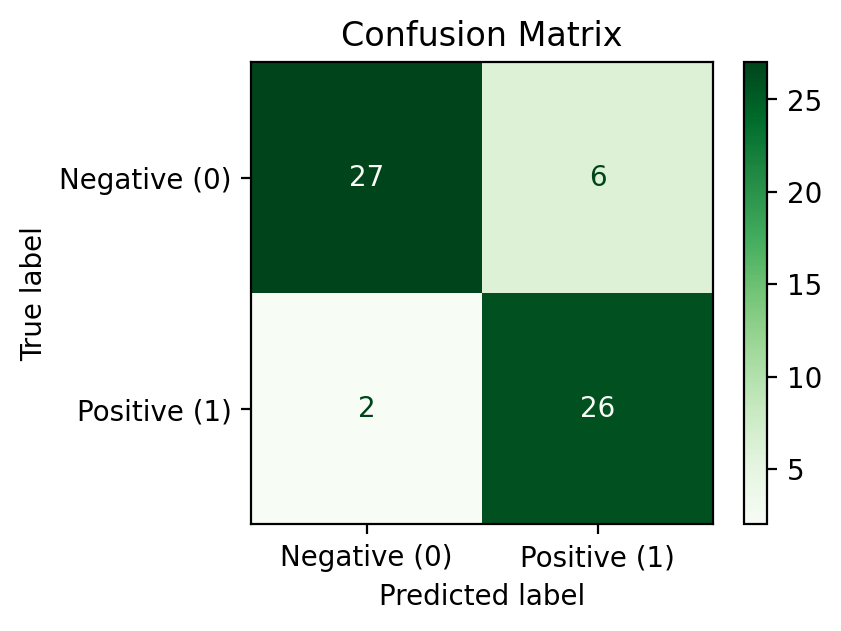

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative (0)", "Positive (1)"])
disp.plot(cmap="Greens")
plt.title("Confusion Matrix")
plt.show()

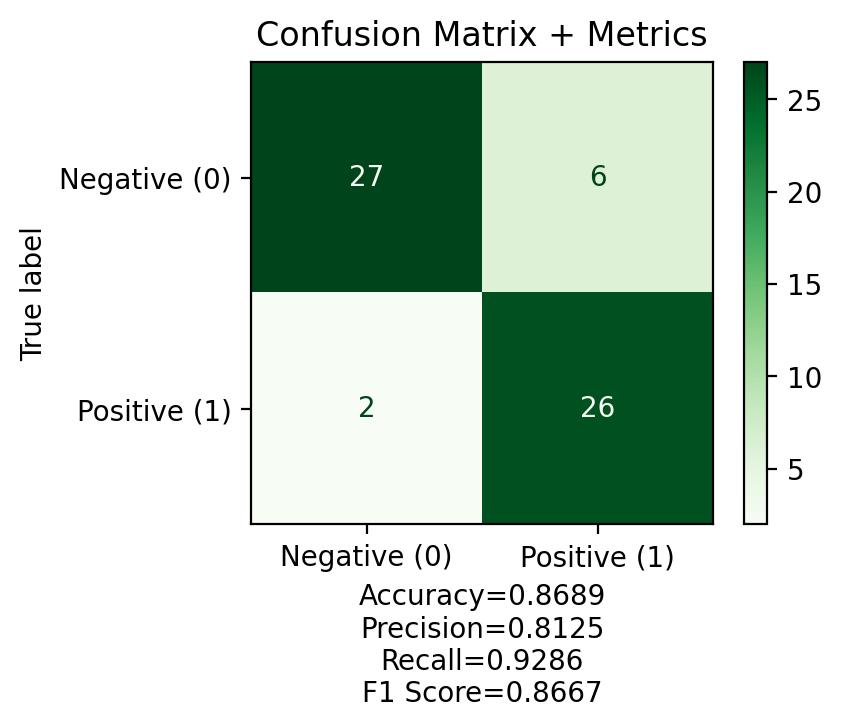

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 혼돈 행렬 계산 및 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative (0)", "Positive (1)"])
disp.plot(cmap="Greens")

# 주요 평가 지표 계산
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# 지표 값을 그림 안에 텍스트로 출력
plt.title("Confusion Matrix + Metrics")
plt.xlabel(f"Accuracy={acc:.4f}\nPrecision={prec:.4f}\nRecall={rec:.4f}\nF1 Score={f1:.4f}")
plt.show()

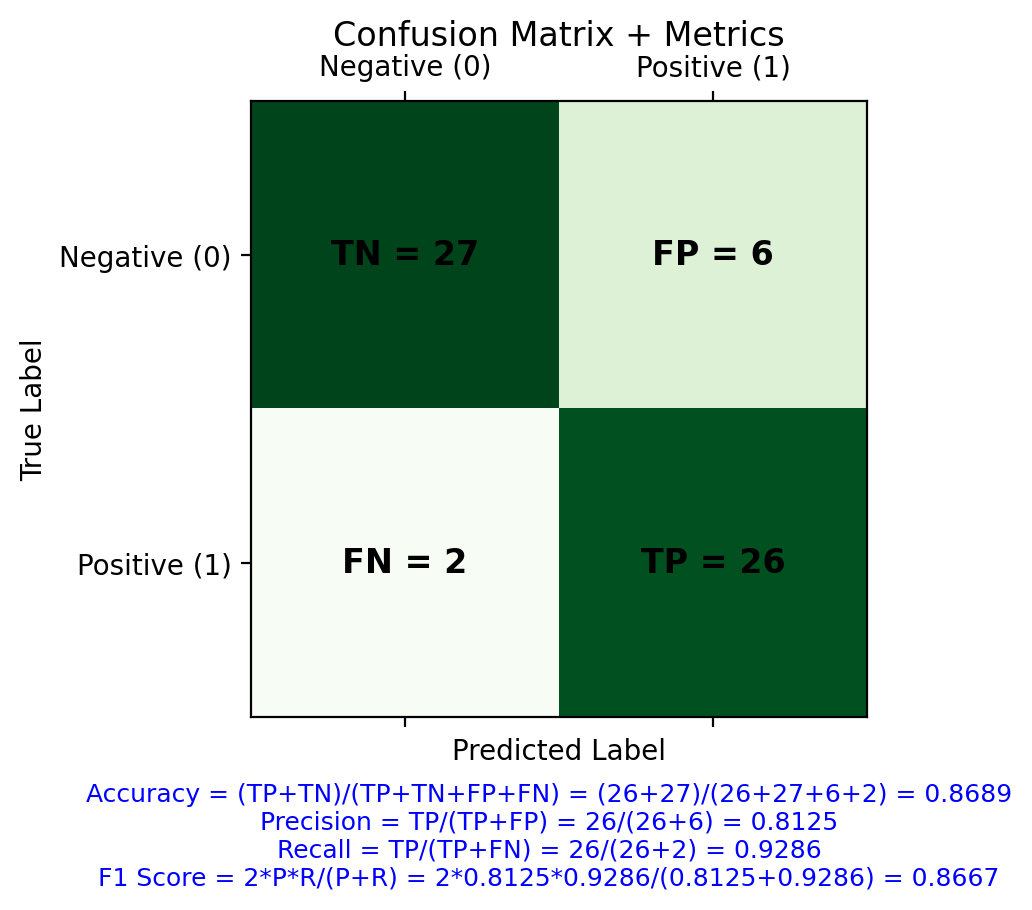

In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# 혼돈 행렬 계산
cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()

# 평가 지표 계산
acc = (TP + TN) / (TP + TN + FP + FN)
prec = TP / (TP + FP) if (TP + FP) > 0 else 0
rec = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

# 시각화
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(cm, cmap="Greens")
plt.title("Confusion Matrix + Metrics", pad=20)

# 축 라벨
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Negative (0)", "Positive (1)"])
ax.set_yticklabels(["Negative (0)", "Positive (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 셀 내부에 TP, TN, FP, FN 텍스트 쓰기
for (i, j), val in np.ndenumerate(cm):
    label = ""
    if i == 1 and j == 1:
        label = f"TP = {val}"
    elif i == 0 and j == 0:
        label = f"TN = {val}"
    elif i == 0 and j == 1:
        label = f"FP = {val}"
    elif i == 1 and j == 0:
        label = f"FN = {val}"
    ax.text(j, i, label, va='center', ha='center', fontsize=12, fontweight='bold')

# 수식 및 결과 문자열을 파란색 소형 폰트로 출력
metrics_text = (
    f"Accuracy = (TP+TN)/(TP+TN+FP+FN) = ({TP}+{TN})/({TP}+{TN}+{FP}+{FN}) = {acc:.4f}\n"
    f"Precision = TP/(TP+FP) = {TP}/({TP}+{FP}) = {prec:.4f}\n"
    f"Recall = TP/(TP+FN) = {TP}/({TP}+{FN}) = {rec:.4f}\n"
    f"F1 Score = 2*P*R/(P+R) = 2*{prec:.4f}*{rec:.4f}/({prec:.4f}+{rec:.4f}) = {f1:.4f}"
)

# 텍스트 박스 형식으로 추가 표시
plt.gcf().text(0.5, -0.1, metrics_text, fontsize=9, color='blue', ha='center')
plt.show()

### 수업종료

## 5강 전체 코드

In [ ]:
# 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# 1. 데이터 불러오기
df = pd.read_csv("heart_disease_zscore.csv")

# 2. 특성과 타겟 분리
X = df.drop(columns=["target"]).astype(np.float32)
y = df["target"].astype(np.float32)

# 3. 훈련/테스트 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42, stratify=y
)

# 4. Dataset 클래스 정의
class HeartDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HeartDataset(X_train, y_train)
test_dataset = HeartDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 5. 모델 정의
class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)  # Sigmoid 제거
        )

    def forward(self, x):
        return self.net(x)

model = DNN(input_dim=X.shape[1])

# 6. 손실함수와 옵티마이저
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# 7. 학습 루프
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f}")

# 8. 평가
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# 9. 결과 출력
print("=== Evaluation Metrics ===")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred, zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred, zero_division=0):.4f}")

Epoch 10 | Loss: 0.6010
Epoch 20 | Loss: 0.4498
Epoch 30 | Loss: 0.3930
Epoch 40 | Loss: 0.3581
Epoch 50 | Loss: 0.3490
=== Evaluation Metrics ===
Accuracy : 0.8689
Precision: 0.8125
Recall   : 0.9286
F1 Score : 0.8667


## 종료